# Exploratory Data Analysis

The Following features were created to evaluate distributions: <br>
- Total Numeber of Projects
- How many updated within the last 30 days
- How many new building
- Most recent status distribution


In [155]:
def recency_groups(x):
    if x<30:
        return '<30'
    elif x<60:
        return '30-60'
    elif x<90:
        return '60-90'
    else:
        return 'Other'
most_recent_update=data.groupby('ProjectName')['Date'].first().reset_index()
most_recent_update['Recency']=pd.to_datetime(most_recent_update['Date'], infer_datetime_format=True).apply(lambda x: (pd.to_datetime('2023-03-23')-x).days)
most_recent_update['RecencyGroup']=most_recent_update['Recency'].apply(lambda x: recency_groups(x))
pie_data=most_recent_update['RecencyGroup'].value_counts().reset_index().rename({'index':'Recency','RecencyGroup':'Count'},axis=1)

In [299]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Pie(
        labels=pie_data.Recency,
        values=pie_data['Count'],
        hole=0.8,
        showlegend=False
    )
)

fig.add_trace(
    go.Bar(
        name='<30',
        x=['<30'],
        y=[pie_data[pie_data.Recency == '<30']['Count'].item()]
    )
)

fig.add_trace(
    go.Bar(
        name='30-60',
        x=['30-60'],
        y=[pie_data[pie_data.Recency == '30-60']['Count'].item()]
    )
)

fig.add_trace(
    go.Bar(
        name='60-90',
        x=['60-90'],
        y=[pie_data[pie_data.Recency == '60-90']['Count'].item()]
    )
)

fig.update_layout(
    title="Permit Application Recency",
    xaxis_title="Recency",
     xaxis_domain=[0.33, 0.67],
     yaxis_domain=[0.33, 0.67]
)

fig.show()

In [242]:
data=pd.read_csv('Toronto_building_permit_info.csv')
stages=data.groupby('ProjectName')['Date'].first().reset_index()
stages=stages.merge(data[['ProjectName', 'Date', 'Application Type']], how='left', on=['ProjectName','Date'])
stages_df=stages['Application Type'].value_counts().reset_index().rename({'index':'Type','Application Type':'Count'},axis=1)
stages_df=pd.concat([stages_df[:5],pd.DataFrame({'Type':'Other','Count':34},index=[15])],axis=0)
stages_df

,Type,Count
0,Building Additions/Alterations,88
1,Mechanical(MS),71
2,Plumbing(PS),63
3,Fire/Security Upgrade,26
4,Small Residential Projects,12
15,Other,34


In [181]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Pie(
        labels=stages_df['Type'],
        values=pie_data['Count'],
        hole=0.8,
        showlegend=False
    )
)

fig.add_trace(
    go.Bar(
        name='Building Additions',
        x=['Building Additions'],
        y=[stages_df[stages_df.Type == 'Building Additions/Alterations']['Count'].item()]
    )
)

fig.add_trace(
    go.Bar(
        name='Mechanical(MS)',
        x=['Mechanical(MS)'],
        y=[stages_df[stages_df.Type == 'Mechanical(MS)']['Count'].item()]
    )
)

fig.add_trace(
    go.Bar(
        name='Plumbing(PS)',
        x=['Plumbing(PS)'],
        y=[stages_df[stages_df.Type == 'Plumbing(PS)']['Count'].item()]
    )
)

fig.update_layout(
    title="Permit Type",
    xaxis_title="Cylinder",
     xaxis_domain=[0.33, 0.67],
     yaxis_domain=[0.33, 0.67]
)

fig.show()

# Model - Sample Selection and Target Variable <br>
Only project with more than one application are considered, the target variable is defined as 1 if the most recent permit application correspondes to a building addition/Alternation type of application, 0 if not.

In [258]:
#data['Date']=pd.to_datetime(data['Date'])
first_date=data.groupby('ProjectName')['Date'].last().reset_index()
first_date.rename({'Date':'FirstAppDate'},axis=1,inplace=True)
last_date=data.groupby('ProjectName')['Date'].first().reset_index()
last_date.rename({'Date':'LastAppDate'},axis=1,inplace=True)
model_df=first_date.merge(last_date, how='left',on='ProjectName')
model_df=model_df[model_df.LastAppDate!=model_df.FirstAppDate]
model_df=model_df.merge(data[['ProjectName','Date','Application Type']], how='left', left_on=['ProjectName','LastAppDate'], right_on=['ProjectName','Date'])
model_df=model_df[[i for i in model_df.columns if i!='Date']]
model_df['Target']=model_df['Application Type'].apply(lambda x: 1 if x=='Building Additions/Alterations' else 0)
print(model_df.Target.value_counts())
model_df=model_df.loc[model_df[['ProjectName','FirstAppDate','LastAppDate']].drop_duplicates().index,:]
model_df=model_df.dropna()
model_df

0    159
1     60
Name: Target, dtype: int64


,ProjectName,FirstAppDate,LastAppDate,Application Type,Target
0,1 BLOOR ST E,2013-09-06,2022-04-19,Fire/Security Upgrade,0
1,1 BLOOR ST W,2015-12-03,2022-05-31,Mechanical(MS),0
3,10 BELLAIR ST,2023-01-13,2023-03-03,Fire/Security Upgrade,0
4,100 BLOOR ST W,2018-10-16,2022-10-11,Building Additions/Alterations,1
8,100 CARLTON ST,2018-04-09,2022-05-02,Mechanical(MS),0
...,...,...,...,...,...
213,94 BLEECKER ST,2022-01-07,2022-04-21,Small Residential Projects,0
215,951 BAY ST,2014-03-14,2022-01-19,Designated Structures,0
216,955 BAY ST,2014-03-14,2022-01-19,Designated Structures,0
217,96 BLEECKER ST,2021-12-13,2022-04-21,Small Residential Projects,0


# Model - Feature Engineering <br>
The following features were constructed using the information prior to the most recent permit application: <br>
- time since last application
- type of the previous application
- number of previous applications
- number of previous BAPP


In [259]:
def number_of_previous_applications(x):
    df=data[(data.ProjectName==x['ProjectName'])&(data['Date']<x['LastAppDate'])]
    return df.shape[0]

def time_last_applpication(x):
    df=data[(data.ProjectName==x['ProjectName'])&(data['Date']<x['LastAppDate'])]
    max_date=pd.to_datetime(df['Date']).max()
    days_since_last=(pd.to_datetime('2023-03-25')-max_date).days
    return days_since_last

def type_prev_app(x):
    df=data[(data.ProjectName==x['ProjectName'])&(data['Date']<x['LastAppDate'])]
    max_date=df['Date'].max()
    df=df[df['Date']==max_date].iloc[0,:]    
    type_prev=df['Application Type']
    
    return type_prev

def number_of_previous_Bapps(x):
    df=data[(data.ProjectName==x['ProjectName'])
            &(data['Date']<x['LastAppDate'])
            &(data['Application Type']=='Building Additions/Alterations')]
    return df.shape[0]
model_df['number_of_previous_applications']=model_df.apply(lambda x:number_of_previous_applications(x),axis=1)
model_df['time_last_applpication']=model_df.apply(lambda x:time_last_applpication(x),axis=1)
model_df['number_of_previous_Bapps']=model_df.apply(lambda x:number_of_previous_Bapps(x),axis=1)
model_df['type_prev_app']=model_df.apply(lambda x:type_prev_app(x),axis=1)
model_df

,ProjectName,FirstAppDate,LastAppDate,Application Type,Target,number_of_previous_applications,time_last_applpication,number_of_previous_Bapps,type_prev_app
0,1 BLOOR ST E,2013-09-06,2022-04-19,Fire/Security Upgrade,0,27,383,8,Mechanical(MS)
1,1 BLOOR ST W,2015-12-03,2022-05-31,Mechanical(MS),0,16,302,8,Building Additions/Alterations
3,10 BELLAIR ST,2023-01-13,2023-03-03,Fire/Security Upgrade,0,35,71,19,Building Additions/Alterations
4,100 BLOOR ST W,2018-10-16,2022-10-11,Building Additions/Alterations,1,6,183,2,Building Additions/Alterations
8,100 CARLTON ST,2018-04-09,2022-05-02,Mechanical(MS),0,3,334,1,Building Additions/Alterations
...,...,...,...,...,...,...,...,...,...
213,94 BLEECKER ST,2022-01-07,2022-04-21,Small Residential Projects,0,1,442,0,Small Residential Projects
215,951 BAY ST,2014-03-14,2022-01-19,Designated Structures,0,9,431,4,Sign Permit
216,955 BAY ST,2014-03-14,2022-01-19,Designated Structures,0,3,431,2,Sign Permit
217,96 BLEECKER ST,2021-12-13,2022-04-21,Small Residential Projects,0,3,465,0,Plumbing(PS)


Categorical features get transformed to dummies

In [286]:
clean_model_df=pd.concat([model_df[['ProjectName',
                                    'Target',
                                    'number_of_previous_applications',
                                    'time_last_applpication',
                                    'number_of_previous_Bapps']]
                          , pd.get_dummies(model_df.type_prev_app)],axis=1)
clean_model_df

,ProjectName,Target,number_of_previous_applications,time_last_applpication,number_of_previous_Bapps,Building Additions/Alterations,Designated Structures,Drain and Site Service,Fire/Security Upgrade,Mechanical(MS),New Building,Plumbing(PS),Sign Permit,Small Residential Projects
0,1 BLOOR ST E,0,27,383,8,0,0,0,0,1,0,0,0,0
1,1 BLOOR ST W,0,16,302,8,1,0,0,0,0,0,0,0,0
3,10 BELLAIR ST,0,35,71,19,1,0,0,0,0,0,0,0,0
4,100 BLOOR ST W,1,6,183,2,1,0,0,0,0,0,0,0,0
8,100 CARLTON ST,0,3,334,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,94 BLEECKER ST,0,1,442,0,0,0,0,0,0,0,0,0,1
215,951 BAY ST,0,9,431,4,0,0,0,0,0,0,0,1,0
216,955 BAY ST,0,3,431,2,0,0,0,0,0,0,0,1,0
217,96 BLEECKER ST,0,3,465,0,0,0,0,0,0,0,1,0,0


# Model - Feature Selection <br>
Information value after optimal binning

In [261]:
from matplotlib import pyplot as plt
import seaborn as sns
from optbinning import OptimalBinning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [270]:
features=[]
IVs=[]
for i in clean_model_df.columns[2:]:
    optb=OptimalBinning(name=i, dtype='numerical', solver='cp')
    optb.fit(clean_model_df[i], clean_model_df['Target'])
    binning_table=optb.binning_table.build()
    IVs.append(binning_table.loc['Totals','IV'])
    features.append(i)
features_df=pd.DataFrame({'Feature_name':features, 'IV':IVs})
features_df.sort_values(by='IV',ascending=False)

,Feature_name,IV
1,time_last_applpication,0.337760
0,number_of_previous_applications,0.115627
2,number_of_previous_Bapps,0.104296
10,Sign Permit,0.056235
7,Mechanical(MS),0.031203
3,Building Additions/Alterations,0.007000
9,Plumbing(PS),0.003578
6,Fire/Security Upgrade,0.000440
4,Designated Structures,0.000000
5,Drain and Site Service,0.000000


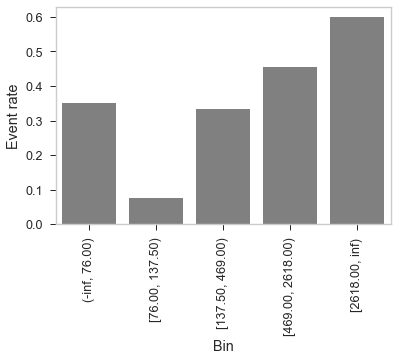

In [295]:
optb.fit(clean_model_df['time_last_applpication'], clean_model_df['Target'])
binning_table=optb.binning_table.build()
plt.figure(figsize=(6,4))
g=sns.barplot(x='Bin', y='Event rate', data=binning_table.iloc[:-3,:],color='grey')
plt.xticks(rotation=90)
plt.show()

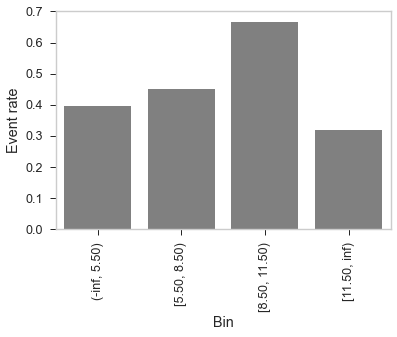

In [296]:
optb.fit(clean_model_df['number_of_previous_applications'], clean_model_df['Target'])
binning_table=optb.binning_table.build()
plt.figure(figsize=(6,4))
g=sns.barplot(x='Bin', y='Event rate', data=binning_table.iloc[:-3,:],color='grey')
plt.xticks(rotation=90)
plt.show()

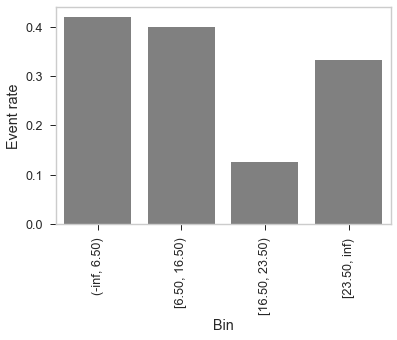

In [298]:
optb.fit(clean_model_df['number_of_previous_Bapps'], clean_model_df['Target'])
binning_table=optb.binning_table.build()
plt.figure(figsize=(6,4))
g=sns.barplot(x='Bin', y='Event rate', data=binning_table.iloc[:-3,:],color='grey')
plt.xticks(rotation=90)
plt.show()

In [284]:
scaler=StandardScaler()
model_vars_feature_selection=['time_last_applpication','number_of_previous_applications'
                              ,'number_of_previous_Bapps','Sign Permit','Mechanical(MS)','Target']
clean_model_df[model_vars_feature_selection[:-3]]=scaler.fit_transform(clean_model_df[model_vars_feature_selection[:-3]])
clean_model_df[model_vars_feature_selection]

C:\Users\juanf\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,time_last_applpication,number_of_previous_applications,number_of_previous_Bapps,Sign Permit,Mechanical(MS),Target
0,-0.729270,0.631546,0.214595,0,1,0
1,-0.813719,0.102352,0.214595,0,0,0
3,-1.054556,1.016415,1.406868,0,0,0
4,-0.937787,-0.378734,-0.435736,0,0,1
8,-0.780356,-0.523060,-0.544125,0,0,0
...,...,...,...,...,...,...
213,-0.667757,-0.619277,-0.652513,0,0,0
215,-0.679226,-0.234408,-0.218959,1,0,0
216,-0.679226,-0.523060,-0.435736,1,0,0
217,-0.643778,-0.523060,-0.652513,0,0,0


In [285]:
clean_model_df=clean_model_df[model_vars_feature_selection]
X, y=clean_model_df.iloc[:,:-1],clean_model_df.iloc[:,-1]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=123) 
logreg1 = LogisticRegression( class_weight='balanced',random_state=0)
logreg1.fit(X_train, y_train)
preds=logreg1.predict(X_test)
proba=logreg1.predict_proba(X_test)
print(confusion_matrix(y_test,preds))
print("AUC -->", roc_auc_score(y_test,proba[:,1]))
print(classification_report(y_test,preds))

[[16 13]
 [ 9  7]]
AUC --> 0.5064655172413792
              precision    recall  f1-score   support

           0       0.64      0.55      0.59        29
           1       0.35      0.44      0.39        16

    accuracy                           0.51        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.54      0.51      0.52        45

